<H1>Authorship in the Federalist Papers</H1>
Use this notebook to replicate the results reporter in the paper  </br>
<ul>
    [1] <a href = https://arxiv.org/abs/1911.01208>
    Kipnis, A., ``Higher Criticism for Discriminating Word-Frequency Tables and Testing Authorship'', 2019
    </a>
</ul>

Use an HC-based test to provide out-of-the-box solution to the case studied in
<ul>
    [2] Mosteller, Frederick, and David L. Wallace. ``<em>Inference in an authorship problem: A comparative study of discrimination methods applied to the authorship of the disputed Federalist Papers</em>''. Journal of the American Statistical Association 58, no. 302 (1963): 275-309.
 </ul>
</br>


In [324]:
m1 = .88
s1 = .063
m2 = .84
s2 = .04
n = 10

sp =np.sqrt( (s1 **2 + s2 **2) / 2)
s = sp * np.sqrt(2/n)
print(s)
z = (m1 - m2) / s
p = scipy.stats.norm.sf(z)
print(p)

0.02359872877932199
0.04503708852994704


0.10213326972553188

In [1]:
import pandas as pd
import numpy as np

#import auxiliary functions for python
import sys
sys.path.append('../AuthAttLib')
from AuthAttLib import *
from visualize_HC_scores import *
from utils import n_most_frequent_words_per_author

<H2>Load Data</H2>

In [2]:
print("loading first 77 Federalists Papers:")
from LoadFederalistPapers import load_Federalists_Papers
fed_papers = load_Federalists_Papers(path = "./Federalist_Papers.txt")

# arrange data in the format accepted by AuthAttribLib.AuthorshipAttributionMulti:
# pandas DataFrame with columns 'doc_id', 'author', 'text'
fed_papers.loc[:,'doc_id'] = fed_papers.paper_no


loading first 77 Federalists Papers:
Documents loaded:
	 43 Hamilton papers
	 14 Madison papers
	 12 disputed papers


### Build vocabulary

In [150]:
#1500 most frequent words by each author, unionized
punct = ['!','?',':',';','"','(',')','-',',','.','`','\`','``','\'\'']
vocab = n_most_frequent_words_per_author(fed_papers[fed_papers.author.isin(['Hamilton','Madison'])], n = 1500, 
                                        words_to_ignore=punct) 
print(f"Vocab size = {len(vocab)}")

Vocab size = 1995


<>:2: DeprecationWarning: invalid escape sequence \`
<>:2: DeprecationWarning: invalid escape sequence \`
<ipython-input-150-7d3cbaf1ef80>:2: DeprecationWarning: invalid escape sequence \`


<H2>Train Model</H2>

In [151]:
train_data = fed_papers[fed_papers.author.isin(['Hamilton','Madison'])]

#prepare model

model = AuthorshipAttributionMulti(train_data,
                                   min_cnt=0,
                                   vocab=vocab,
                                   gamma=0.2)

<H3> Asses prdictability using leave-one-out HC scores </H3>

In [152]:
df = model.compute_inter_similarity(LOO = True, wrt_authors=['Hamilton', 'Madison'])

/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more detai

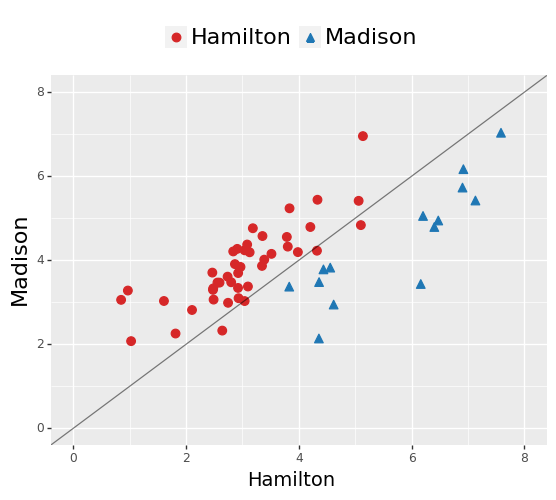

/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 5 x 3.5 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: HC_Hamilton_vs_Madison.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


<ggplot: (346704999)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [153]:
# illustrate HC scores 
path_to_plots = ""


plotnine.options.figure_size = (6.4, 4.8)
p = (plot_author_pair(df, value = 'HC') + 
     theme(legend_title = element_blank(), legend_position = "top",
              plot_title = element_text(hjust = 0.5, size=16), 
                legend_text=element_text(size=16),
              axis_title_x = element_text(size = 14),
              axis_title_y = element_text(size = 16)) #+ xlim(4,10) + ylim(4,10)
    ) + xlim(0,8) + ylim(0,8)

print(p)
p.save(path_to_plots + 'HC_Hamilton_vs_Madison.png', height = 3.5 , width = 5)

<H2>Evaluate HC Scores of Disputed Papers</H2>

100%|██████████| 2/2 [00:00<00:00,  2.32it/s]
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` 

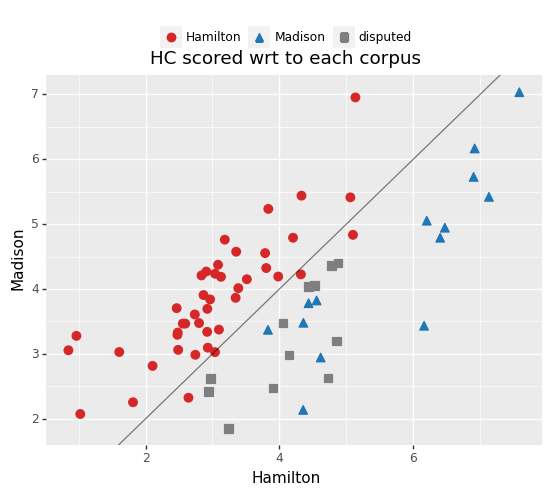

<ggplot: (347867612)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.

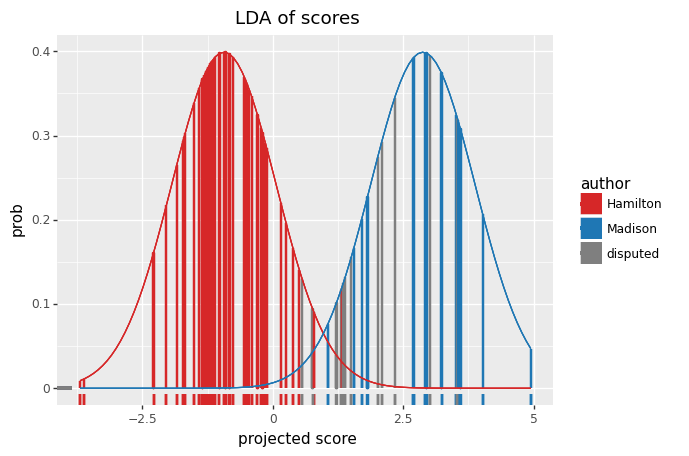

<ggplot: (346464293)>


In [154]:
# Authiorship of disputed papers:
data_disputed = fed_papers[fed_papers.author == 'disputed']

# In order to get the results in [1], set LOO=True 
df_disputed = model.stats_list(data_disputed, LOO = True)  

# illustrate HC scores

df_all = pd.concat([df, df_disputed], sort = True)

p = plot_author_pair(df_all, value = 'HC', wrt_authors=['Hamilton','Madison'])
print(p + ggtitle("HC scored wrt to each corpus"))

p = plot_LDA(df_all, value = 'HC',
             wrt_authors=['Hamilton','Madison']
            )
print(p + ggtitle("LDA of scores"))


<H2>P-values in rank-based test</H2>

/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more detai

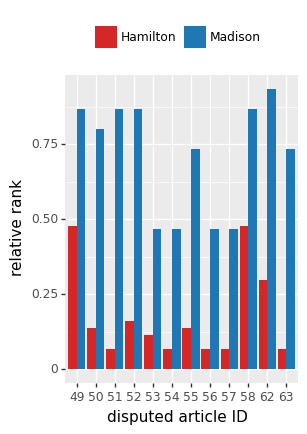

<ggplot: (347857532)>


In [161]:
# P-values in rank-based test:

plotnine.options.figure_size = (3, 4) #height = 8, width = 5
df_all.loc[:,'pval'] = 1-df_all.loc[:,'HC_rank']

p = plot_author_pair_col(df_all, value = 'pval', wrt_authors = ('Hamilton', 'Madison'), test_author='disputed') +\
theme(legend_title=element_blank(), legend_position='top') + ylab('relative rank') + xlab('disputed article ID')
print(p)


<H2>Discriminiating Words</H2>

/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more detai

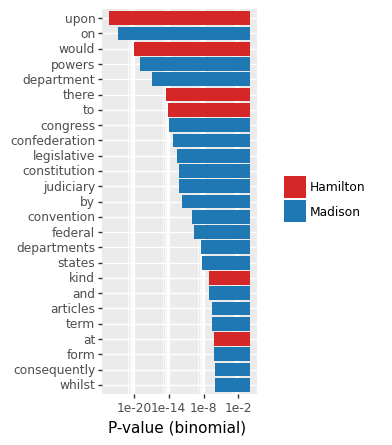

<ggplot: (350879088)>


/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more detai

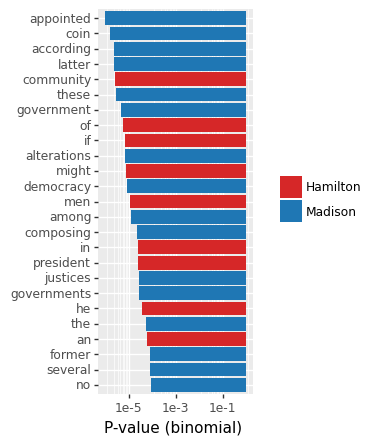

<ggplot: (351133061)>


/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more detai

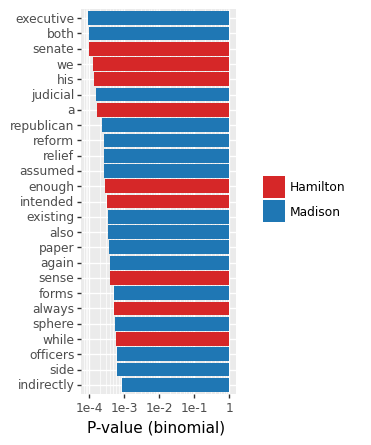

<ggplot: (350721627)>


In [169]:
# word discriminating between the two corpora:
df1 = model.two_author_test('Hamilton','Madison')
df1 =df1.sort_values('pval')

df_discriminating = df1[~np.isnan(df1.sign)]
plotnine.options.figure_size = (2, 5)

for i in [0,1,2] :
    k = 25
    p = plot_col(df_discriminating.rename(columns={'feature' : 'term'})[i*k:k*(i+1)],
                 value='pval',sign='sign',wrt_authors=('Hamilton','Madison'),
                ) + theme(legend_title=element_blank(), legend_position=element_blank()) + ylab('P-value (binomial)')
    print(p)

<H1> Using ``non-contextual'' words from [1]</H1>

In [39]:
MW_final = ["upon", "also" ,"an", "by" , "of", "on", "there", "this", "to", "although", "both", "enough", 
    "while", "whilst", "always", "though", "commonly", "consequently", "considerable",
    "according", "apt", "direction", "innovation", "language", "vigor", "kind",
    "matter", "particularly", "probability", "work"]

function_words =  ['a','as','do','has','is','no','or','than','this','when',
  'all','at','down','have','it','not','our','that','to','which',
  'also','be','even','her','its','now','shall','the','up','who',
  'an','been','every','his','may','of','should','their','upon','will',
  'and','but','for','if','more','on','so','then','was','with',
  'any','by','from','in','must','one','some','there','were','would',
  'are','can','had','into','my','only','such','thing','what','your']

# two list of additional words used by Mosteller & Wallace
additional_words1 = ['affect','city','direction','innovation','perhaps','vigor',
                    'again','commonly','disgracing','join','rapid','violate','although',
                    'consequently','either','language','sarne','violence','among','considerable',
                    'enough','most','second','voice','another','contribute','nor','still',
                    'where','because','defensive','fortune','offensive','those','whether',
                    'between','destruction','function','often','throughout', 'while','both',
                    'did','himself','pass','under','whilst']

additional_words2 = ['about','choice','proper','according','common','kind','propriety','adversaries',
                    'danger','large','provision','after','decide','decides','decided','deciding',
                    'likely','requiisite','aid','degree','matters','matter','substance','always',
                    'during','moreover','they','apt','expence','expences','necessary','though',
                    'asserted','expenses','expense','necessity','necessities','truth','truths',
                    'before','extent','others','us','being','follows','follow','particularly',
                    'usages','usage','better','I','principle','we','care','imagine','edit','editing',
                    'probability','work']

MW_vocab = function_words + additional_words1 + additional_words2


from text_processing import remove_parts_of_speach

def lemmatize_vocab(list_of_words) :
    return remove_parts_of_speach(" ".join(list_of_words), to_remove=[]).split()

# use 176 words considered in [1] :
vocab = lemmatize_vocab(MW_final)

In [40]:
train_data = fed_papers[fed_papers.author.isin(['Hamilton','Madison'])]
model_NC = AuthorshipAttributionMulti(train_data, 
                                      vocab = MW_vocab
                                     )

../AuthAttLib/AuthAttLib.py:362: DeprecationWarning: Use 'AuthorshipAttributionMulti.compute_inter_similarity' and 'AuthorshipAttributionMulti.get_inter_similarity' instead.
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by 

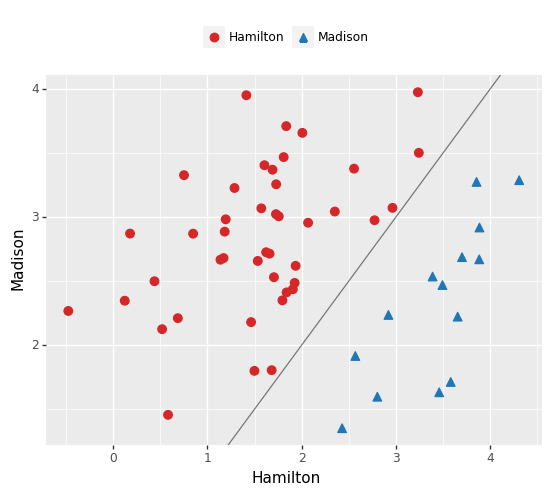

<ggplot: (354698762)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


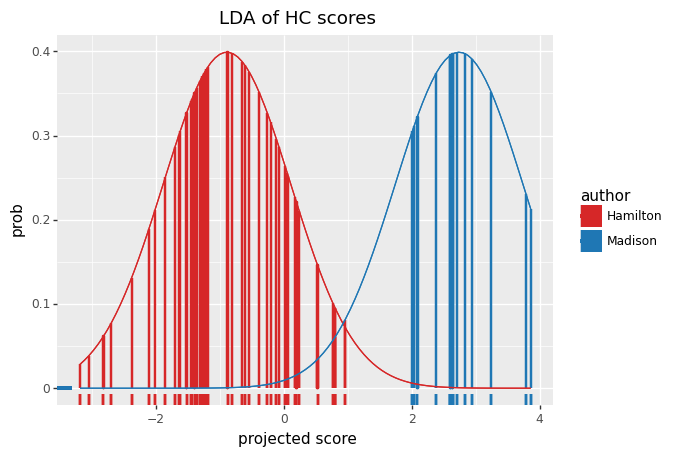

<ggplot: (354711381)>


In [41]:
# HC score of each document with respect to the rest in training set
df_NC = model_NC.internal_stats()

# illustrate HC scores 
p = plot_author_pair(df_NC, value = 'HC')
print(p)

p = plot_LDA(df_NC, value = 'HC', wrt_authors=('Hamilton','Madison'))
print( p + ggtitle('LDA of HC scores'))

100%|██████████| 2/2 [00:00<00:00, 11.75it/s]
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` 

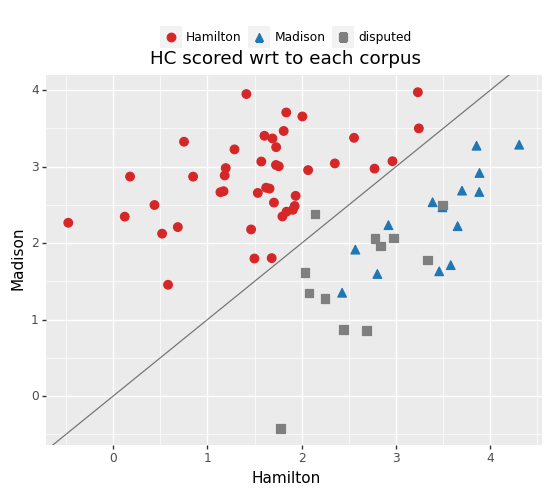

<ggplot: (354724175)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.

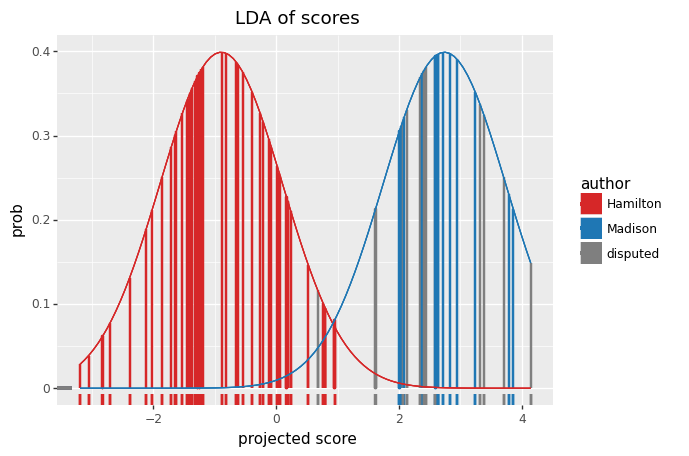

/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


<ggplot: (354813109)>


/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.8/site-packages/plotnine/guides/guide_legend.py:302: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


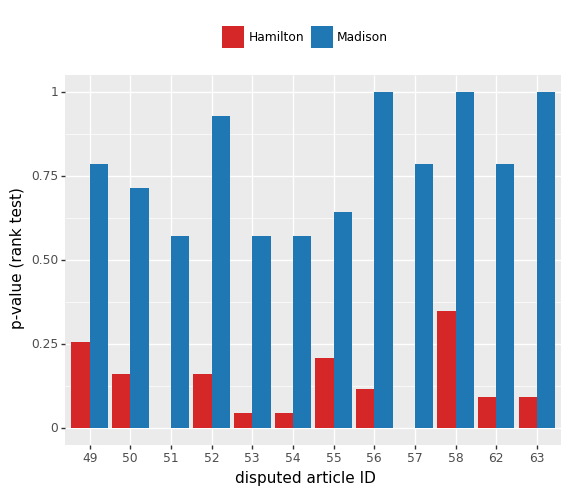

<ggplot: (354724184)>


In [42]:
# Authiorship of disputed papers:
data_disputed = fed_papers[fed_papers.author == 'disputed']

# In order to get the results in [1], set LOO=True 
df_NC_disputed = model_NC.stats_list(data_disputed, LOO = False)  

# illustrate HC scores

df_NC_all = pd.concat([df_NC, df_NC_disputed], sort = False)

p = plot_author_pair(df_NC_all, value = 'HC', wrt_authors=['Hamilton','Madison'])
print(p + ggtitle("HC scored wrt to each corpus"))

p = plot_LDA(df_NC_all, value = 'HC',
             wrt_authors=['Hamilton','Madison']
            )
print(p + ggtitle("LDA of scores"))


# P-values in rank-based test:
df_NC_all.loc[:,'pval'] = 1-df_NC_all.loc[:,'HC_rank']

p = plot_author_pair_col(df_NC_all, value = 'pval', wrt_authors = ('Hamilton', 'Madison'), test_author='disputed') +\
theme(legend_title=element_blank(), legend_position='top') + ylab('p-value (rank test)') + xlab('disputed article ID')
print(p)


/usr/local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:177: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead


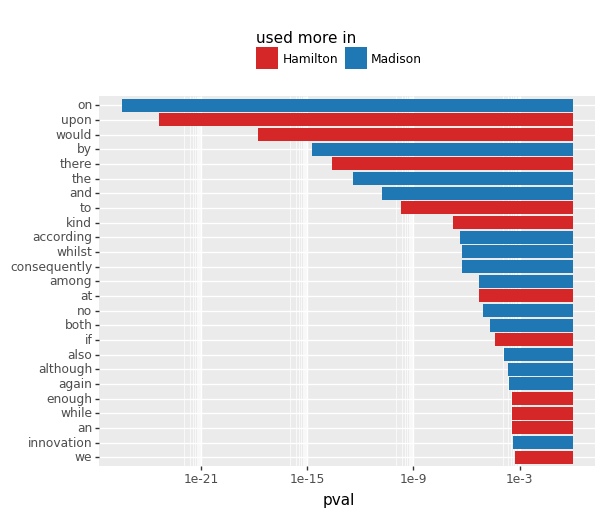

<ggplot: (309565742)>


In [17]:
# word discriminating between the two corpora:
df1 = model_NC.two_author_test('Hamilton','Madison')
df1 = df1.sort_values('pval')

df_discriminating = df1[df1.thresh]

n = len(df_discriminating)

for i in range(int(n/k+0.5)) :
    k = 25
    p = plot_col(df_discriminating.rename(columns={'feat' : 'term'})[i*k:k*(i+1)],
                 value='pval',sign='sign',wrt_authors=('Hamilton','Madison'))
    print(p)

# Illustrate Three Fequency Table

In [285]:
import plotnine

plotnine.options.figure_size = (3, 5)

all_data = fed_papers[fed_papers.author.isin(['Hamilton','Madison', 'disputed'])]

#prepare model

model = AuthorshipAttributionMulti(all_data,
                                   min_cnt=0,
                                   vocab=vocab,
                                   gamma=0.2)

In [286]:
k = 60
k1 = 500
f1 = model._AuthorModel['Hamilton']._counts
f2 = model._AuthorModel['Madison']._counts

dtm = model._AuthorModel['disputed']._dtm
i = np.random.randint(dtm.shape[0])
f3 = np.asarray(dtm[i].todense())[0]
df = pd.DataFrame({'word' : vocab, 'Hamilton' : f1 / f1.sum(), 'Madison' : f2 / f2.sum(), 'disputed' : f3/f3.sum()})

df['total'] = df['Hamilton'] + df['Madison'] + df['disputed']
df = df.sort_values('total', ascending=False)\
       .head(k1)\
       .sample(n=k)\
       .sort_values('total', ascending=False)\
       .reset_index()\
       .drop(['index','total'], axis=1)
       
lo_words = df.word.tolist()[::-1]
df['word'] = pd.Categorical(df['word'], categories = lo_words)

/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3 x 5 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: word_freq_table_exm_0.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in

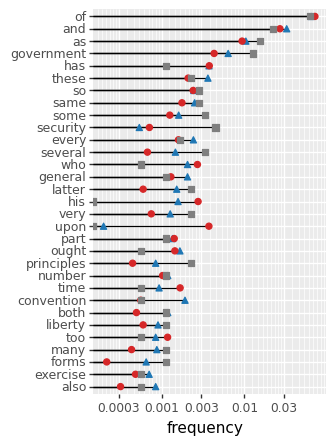

<ggplot: (348063919)>


/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 3 x 5 in image.
/usr/local/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: word_freq_table_exm_1.png
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in

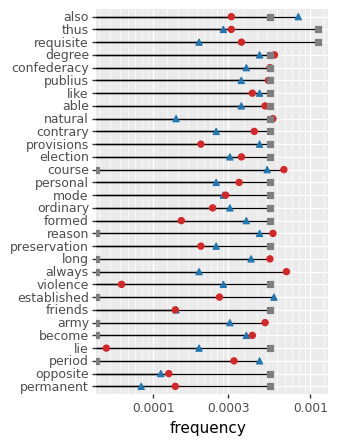

<ggplot: (349730829)>


In [289]:

#df1['f'] = -np.log10(df1['f'])
L = len(df) // 2

for i in [0, 1] :
    df1 = df.loc[i*L:(i+1)*L,:].melt(id_vars = 'word', var_name = 'author', value_name= 'f')
    p = (ggplot(aes(x = 'word', y = 'f', shape='author'), data=df1) + 
             #geom_bar(position='dodge', stat="identity", show_legend=False, size=.5) +
             geom_segment(aes(xend='word', y=0, yend='f', fill='word'), show_legend=False) +
             geom_point(aes(color='author'), show_legend=False, size=2) +
             scale_color_manual(values = LIST_OF_COLORS) +
             coord_flip() + 
             ylab('frequency') +
             xlab('') +
             scale_y_log10() +
             theme(legend_position='top', legend_title=element_blank(),
                     legend_text=element_text(size=13),
                     axis_text_y=element_text(size=9)
                                )

            )
    p.save(f"word_freq_table_exm_{i}.png")
    print(p)